For each Wasm binary we have a three (non-simetric) space where the dimensions are: the mutator, the variants that the mutator generetes and the iteration of the mutation. Notice that the third dimension (the iteration of the mutator) also generates another space for the new mutation. This space can be represented as the following tree. 

The root of the tree is an arbitrary binary, and two levels below the binary, we reprenset the applicable mutations and the variants.


```

                binary
           /       |         \
dim0 ->   M1       M2         M3
         /  \    / |  \    /  |   \
dim1 -> v1  v2  v1 v2 v3  v1 ...  vn
         |
dim2 -> M1 ...
```

This tree offers some interesting properties.
- If the second or third level below the binary are empty, then the binary cannot be mutated
- If the order of the mutators are always the same, we can map an interesting variant with the applied mutators from the leaf to the root. 

Now, the question is how we generate the space. As we mentioned, some mutators generate infinite variants. Therefore, is impossible to generate the subtree for them. On the other hand, the tree has and infinite height, i.e. we can mutate the root binary as many times we needed (going down and down in the tree).

To solve the first issue we need to sample the mutators that generate an infinite number of variants.
For the second issue, we implement the construction of the tree for each variant up to two levels lazily. 



In the following list we enumerate the mutators, if they affect the execution (in terms of performance only, notice we only apply semantic equivalent transformations), if they increase/reduce the size of the variants (hint on the complexity of the variant),  a formula to calculate the number of variants they generate and how we can sample them.

| Mutator | Description | Affect execution | Affect size |  Number of variants |  Sample method |
|--       | --          |------     |----                 | ------         | ----        |
| PeepholeMutator| Creates an egraph based in rewriting rules for peephole transformations. In practice, this mutator has a fixed limit, usually on the height of the generated subtree.  | X | X | **oo** | Let **H** the maximum height, **M** the maximum number of trees that we can generate from the egraph (our **oo**) and **T** all the places valid for the generation of an egraph. The number of variants $$ |V| \le \Sigma_{1}^{T}\Sigma_{1}^{H}| egraph(H).trees. | $$ **This is extremely expensive $$ O(I\times M\times H) $$**  |
| CodemotionMutator| Unroll a **loop** or invert an **if** contruction. | | | \|loops\| + \|ifs\| | \|loops\| + \|ifs\||
| AddTypeMutator| Add a (1) random type to the type definition of the binary. | | | 1 (add a new type) | 1 |
| AddFunctionMutator| Add a new random function to the function and code sections. | | X | 1 | 1 |
| RemoveItemMutator(Item::Function)| Removes a random function (to be semantically equivalent, the function needs not to be exported or used |  | X | \|functions\| | \|functions\| |
| RemoveItemMutator(Item::Global)| Removes a global |  | X | \|globals\| | \|globals\| |
| RemoveItemMutator(Item::Memory)| Removes a memory |  | X | \|memories\|| \|memory\| |
| RemoveItemMutator(Item::Table)| Removes a table | | X | \|tables\| | \|tables\| |
| RemoveItemMutator(Item::Type)| Removes a type | | X | \|types\| | \|types\| |
| RemoveSection::Custom| Removes a custom section | | X | \|customs\| | \|customs\| |
| CustomSectionMutator| Changes the data or the name of the custom section | | X | 2\|customs\| | 2\|customs\| |
| RemoveSection::Empty| Removes an empty section | | X | \|empty\| | \|empty\| |


We built a tool able to generate the two dimensions of the mutation space for a given binary.

Given a binary, this tools provides the following info:
    
```json

"id": "59955b4c538d0b45961e19b70c4ab7a101968561a353186045bde628c0d72dbb.wasm",
    ...
    "mutations": [
      {
        "class_name": "PeepholeMutator::new(10)",
        ...
        "map": [
            ... Where to apply it
        ],
      },
      {
        "class_name": "CodemotionMutator",
        ...
        "map": [
            ... Where to apply it
        ],
      },
      {
        "class_name": "AddTypeMutator { max_params: 20, max_results: 20 }",
        ...
        "map": [
            ... Where to apply it
        ],
      },
      {
        "class_name": "AddFunctionMutator",
        ...
        "map": [
            ... Where to apply it
        ],
      },
      {
        "class_name": "RemoveItemMutator(Item::Function)",
        ...
        "map": [
            ... Where to apply it
        ],
      },
      {
        "class_name": "RemoveItemMutator(Item::Global)",
        ...
        "map": [
            ... Where to apply it
        ],
      },
      {
        "class_name": "RemoveItemMutator(Item::Memory)",
        ...
        "map": [
            ... Where to apply it
        ],
      },
      {
        "class_name": "RemoveItemMutator(Item::Table)",
        ...
        "map": [
            ... Where to apply it
        ],
      },
      {
        "class_name": "RemoveItemMutator(Item::Type)",
        ...
        "map": [
            ... Where to apply it
        ],
      }

```

Given this info and the previous presented table, we can answer for example, how many variants this binary will generate with one iteration of the mutators. This can be calculated using the *sample method* of the table. In practice we would only need count the size of the `map` property in the previous json.

PeepholeMutator::new(10) 8459
CodemotionMutator 8459
AddTypeMutator { max_params: 20, max_results: 20 } 8460
AddFunctionMutator 8460
RemoveItemMutator(Item::Function) 8459
RemoveItemMutator(Item::Global) 6453
RemoveItemMutator(Item::Memory) 8294
RemoveItemMutator(Item::Table) 7581
RemoveItemMutator(Item::Type) 8460
RemoveSection::Custom 2697
CustomSectionMutator 2697
RemoveSection::Empty 126


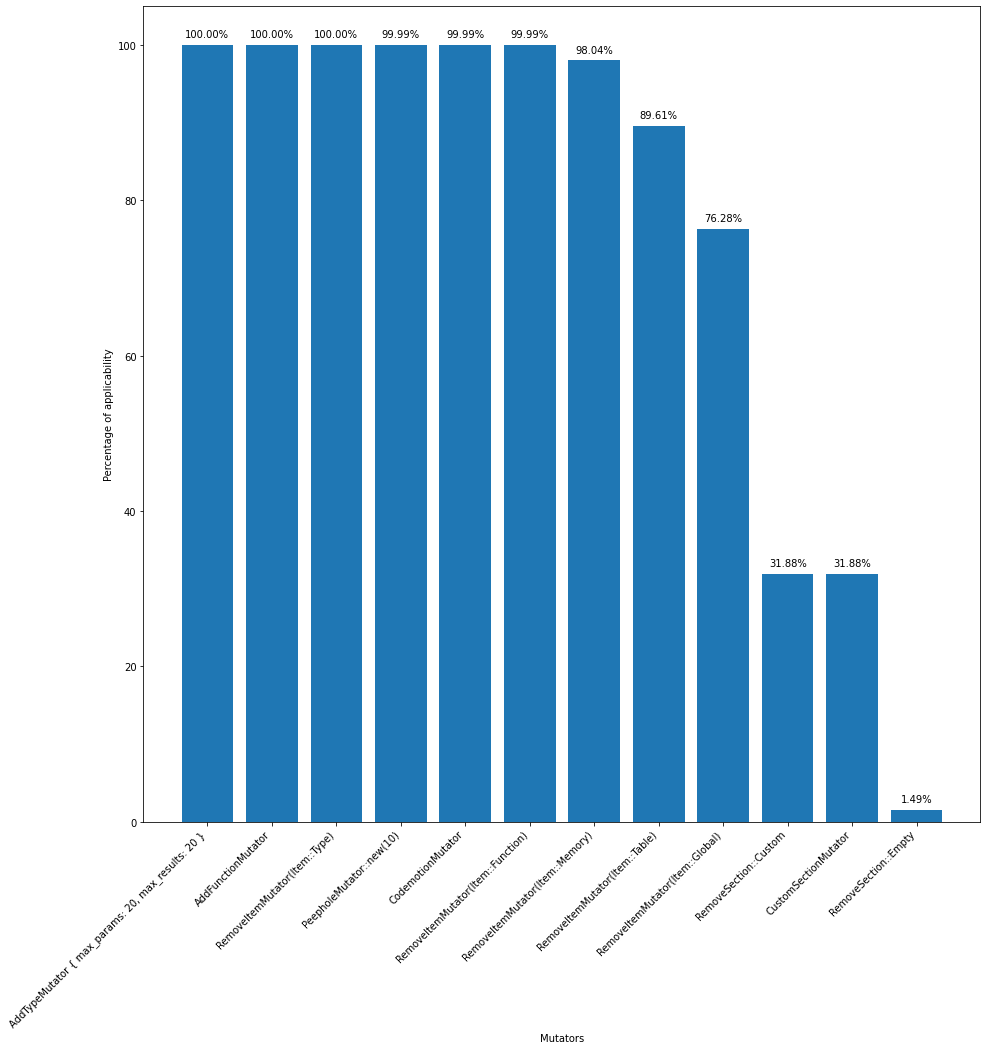

In [1]:
from utils import load_sets
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]


sets, total, binaries = load_sets("all.json")

# print mutable
def plot_bars(sets, total):
    bins = [ (k, 100*len(v)/total) for k, v in sets ]
    xs = [ k for k,_ in sets ]

    bins = sorted(bins, key= lambda x: x[1], reverse= True )

    pps = plt.bar([x[0] for x in bins], [x[1] for x in bins])
    for p in pps:
        height = p.get_height()
        plt.text(x=p.get_x() + p.get_width() / 2, y=height+1, s="{:.2f}%".format(height),ha='center')

    plt.xticks(rotation='45',ha='right')
    plt.xlabel("Mutators")
    plt.ylabel("Percentage of applicability")
    
    
plot_bars(sets, total)

In [7]:
import pandas as pd

# create the collection and count the number of variants per mutator

df = pd.DataFrame()

for record in binaries:
    mutations = record['mutations']
    record = {}
    for m in mutations:
        cname = m['class_name']
        if 'Peephole' in cname:
            record[cname] = 'oo'
        if 'Codemotion' in cname:
            record[cname] = '|loops| + |ifs|'# count map
        if 'AddFunction' in cname or 'AddType' in cname:
            record[cname] = 1


    df = df.append(record, ignore_index = True)
display(df)

,PeepholeMutator::new(10),CodemotionMutator,"AddTypeMutator { max_params: 20, max_results: 20 }",AddFunctionMutator
0,oo,|loops| + |ifs|,1.0,1.0
1,oo,|loops| + |ifs|,1.0,1.0
2,oo,|loops| + |ifs|,1.0,1.0
3,oo,|loops| + |ifs|,1.0,1.0
4,oo,|loops| + |ifs|,1.0,1.0
...,...,...,...,...
8455,oo,|loops| + |ifs|,1.0,1.0
8456,oo,|loops| + |ifs|,1.0,1.0
8457,oo,|loops| + |ifs|,1.0,1.0
8458,oo,|loops| + |ifs|,1.0,1.0
